# Text based product similarity

In [1]:
# importing all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data = pd.read_pickle('/content/drive/MyDrive/Data sets/16k_apperal_data_preprocessed')

data.head()

asin  ... formatted_price
4   B004GSI2OS  ...          $26.26
6   B012YX2ZPI  ...           $9.99
15  B003BSRPB0  ...          $20.54
27  B014ICEJ1Q  ...           $7.39
46  B01NACPBG2  ...           $6.95

[5 rows x 7 columns]

##  Bag of Words (BoW) on product titles.

In [16]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features   = tfidf_title_vectorizer.fit_transform(data['title'])

print(tfidf_title_features.shape)

(16434, 12684)


In [17]:
# credits: https://www.kaggle.com/c/word2vec-nlp-tutorial#part-2-word-vectors
# Custom Word2Vec using your own text data.
# Do NOT RUN this code.
# It is meant as a reference to build your own Word2Vec when you have 
# lots of data.

'''
# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 1    # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
from gensim.models import word2vec
print ("Training model...")
model = word2vec.Word2Vec(sen_corpus, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context)
    
'''

'\n# Set values for various parameters\nnum_features = 300    # Word vector dimensionality                      \nmin_word_count = 1    # Minimum word count                        \nnum_workers = 4       # Number of threads to run in parallel\ncontext = 10          # Context window size                                                                                    \ndownsampling = 1e-3   # Downsample setting for frequent words\n\n# Initialize and train the model (this will take some time)\nfrom gensim.models import word2vec\nprint ("Training model...")\nmodel = word2vec.Word2Vec(sen_corpus, workers=num_workers,             size=num_features, min_count = min_word_count,             window = context)\n    \n'

In [18]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''

# if you do NOT have RAM >= 12GB, use the code below.
with open('/content/drive/MyDrive/Case Studies/Amazon Fashion Discovery /word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [19]:
# Utility functions

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id   : document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  title_vectorizer.vocabulary_:
                vec.append(title_features[doc_id, title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)
# Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)

def get_distance(vec1, vec2):
    # vec1 = np.array(# number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in given title
    # vec2 = np.array(# number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in given title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(# number of words in title1 * # number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [20]:
print(model.keys())

print(len(model.keys()))

print(model['como']) # will print the vector corresponding the word 'como'

print(len(model['como'])) # of size 300

dict_keys(['minions', 'como', 'superheroes', 'ironman', 'long', 'sleeve', 'round', 'neck', 'tshirt', 'women', '', 'fig', 'clothing', 'womens', 'izo', 'tunic', 'top', 'focal18', 'sailor', 'collar', 'bubble', 'blouse', 'shirt', 'mori', 'girl', 'casual', 'harajuku', 'featherlite', 'ladies', 'stain', 'resistant', 'tapered', 'twill', '2xl', 'onyx', 'black', 'stone', 'fits', 'cloth', 'grape', 'solid', 'modern', 'plain', 'unique', '100', 'cotton', 'special', 'olympics', 'world', 'games', '2015', 'white', 'size', 'l', 'floerns', 'bell', 'beading', 'standing', 'promises', 'rhinestones', 'ripped', 'cut', 'red', 'fila', 'tulip', 'durable', 'tennis', 'style', 'comfort', 'tank', 'cold', 'shoulder', 'print', 'ruffle', '2x1', 'ribbed', 'fifteen', 'twenty', 'grommet', 'tie', 'yellow', 'shirtdance', 'short', 'sleeves', 'graphic', 'soft', 'fedi', 'apparel', 'vneck', 'tops', 'camouflage', 'tee', 'moisture', 'free', 'mesh', 'sport', 'xxxlarge', 'fea', 'merchandising', 'juniors', 'florida', 'georgia', 'lin

In [21]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if we are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentence: its title of the apparel
    # num_features: the length of word2vec vector and its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if  m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32") # Initializing the word vector with all Zeros.
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split(): # split the sentence into tokens 
        nwords += 1
        if word in vocab: # if words is present in the vocabulary of word2vec
            if m_name == 'weighted' and word in  tfidf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])# https://numpy.org/doc/stable/reference/generated/numpy.add.html 
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords) # Dividing by the number of words to get the average.
        # https://numpy.org/doc/stable/reference/generated/numpy.divide.html 
    
    return featureVec # # returns the avg vector of given sentance, its of shape (1, 300)

### Average Word2Vec product similarity.

In [22]:
doc_id = 0
w2v_title = []
# for every title we build an average vector representation
for sentence in data['title']:
    w2v_title.append(build_avg_vec(sentence, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title = np.array(w2v_title) # making it numpy array


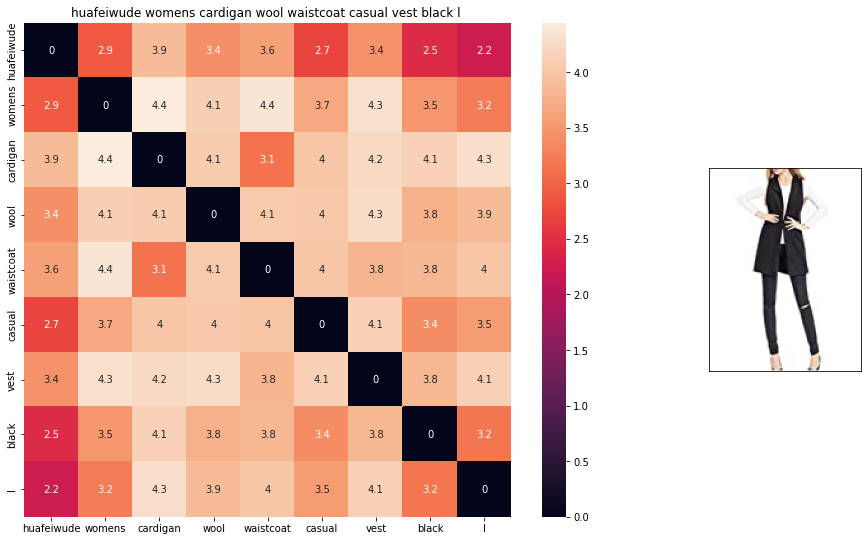

ASIN : B01MT96PXZ
BRAND : Huafeiwude
euclidean distance from given input image : 0.0


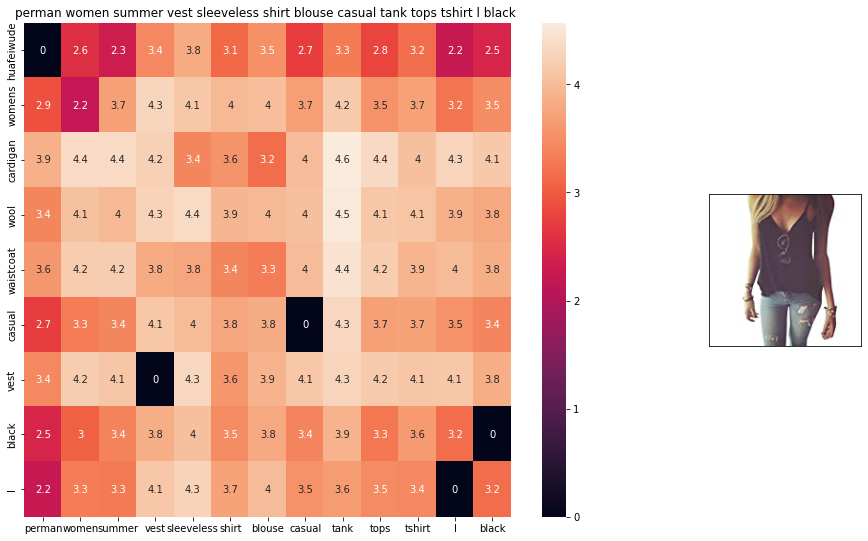

ASIN : B01F852VDK
BRAND : Perman
euclidean distance from given input image : 0.8539957


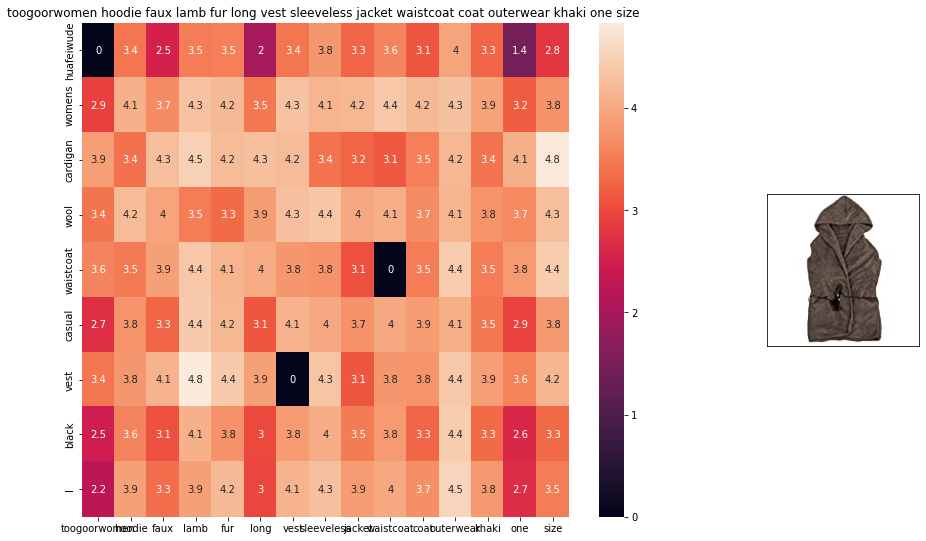

ASIN : B00R10GCHC
BRAND : TOOGOO(R)
euclidean distance from given input image : 0.8619427


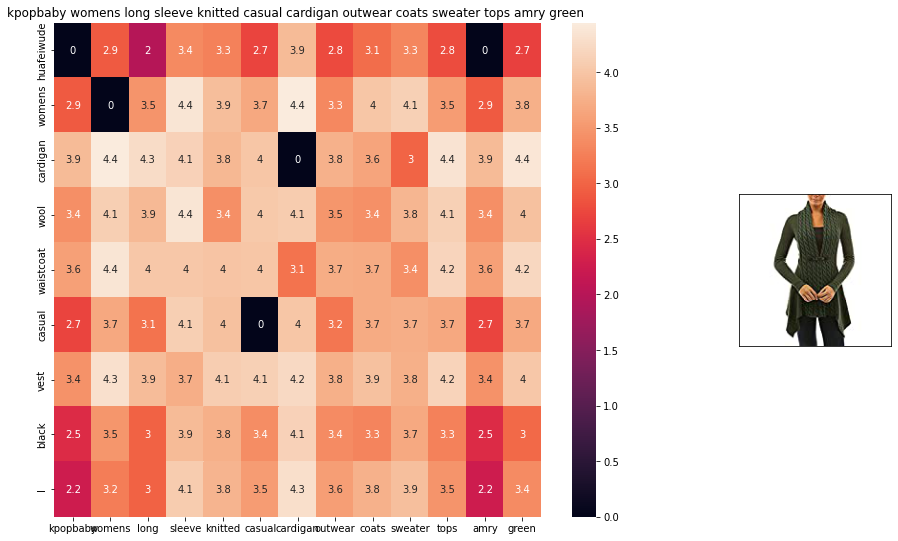

ASIN : B074LD7G7K
BRAND : KpopBaby
euclidean distance from given input image : 0.87473196


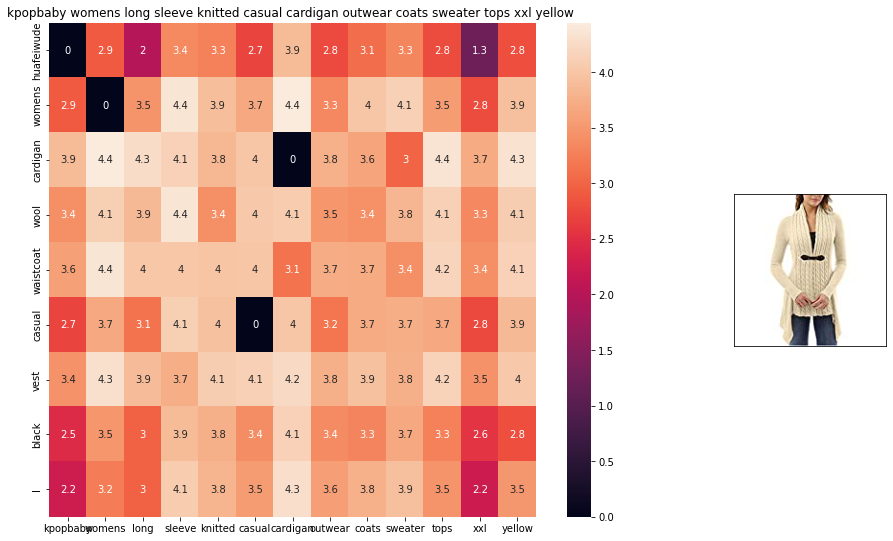

ASIN : B074LCPJJZ
BRAND : KpopBaby
euclidean distance from given input image : 0.88326466


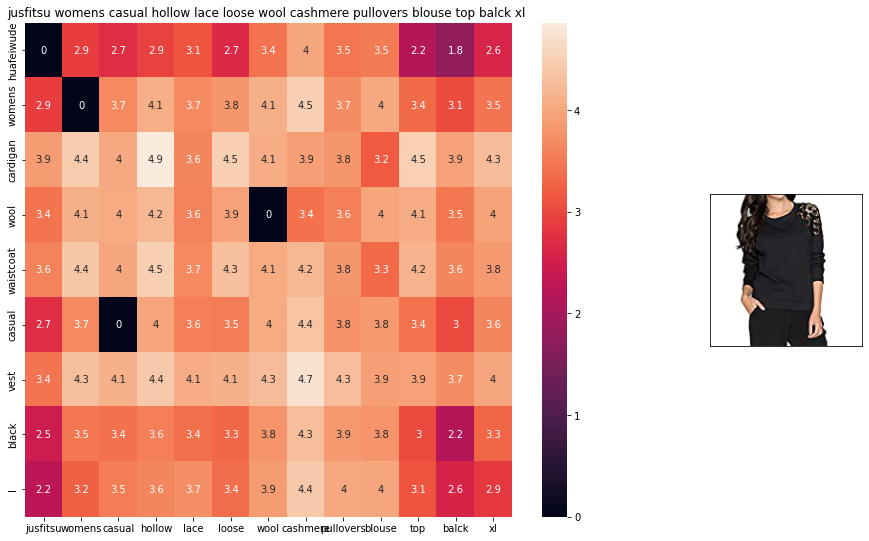

ASIN : B01N96GX38
BRAND : Jusfitsu
euclidean distance from given input image : 0.8868851


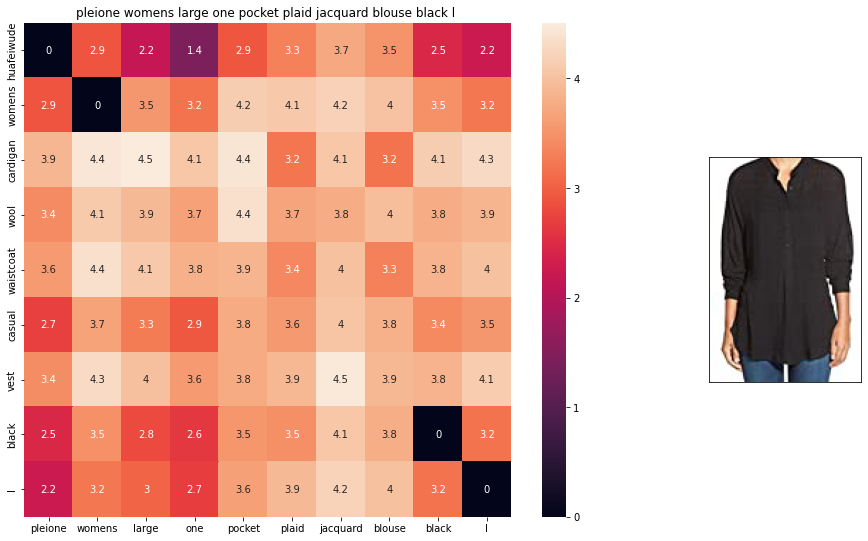

ASIN : B06XGQ9CSM
BRAND : Pleione
euclidean distance from given input image : 0.8881678


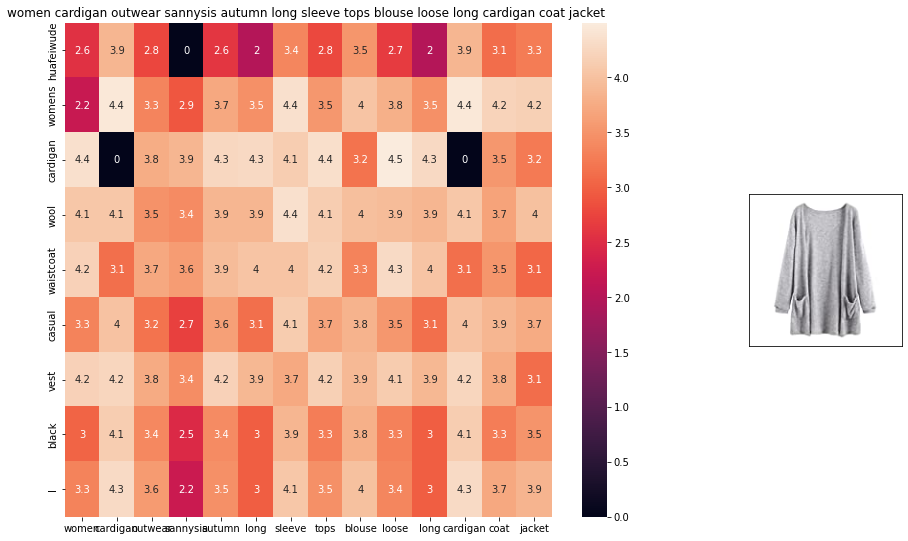

ASIN : B07473KFK1
BRAND : Sannysis
euclidean distance from given input image : 0.89271647


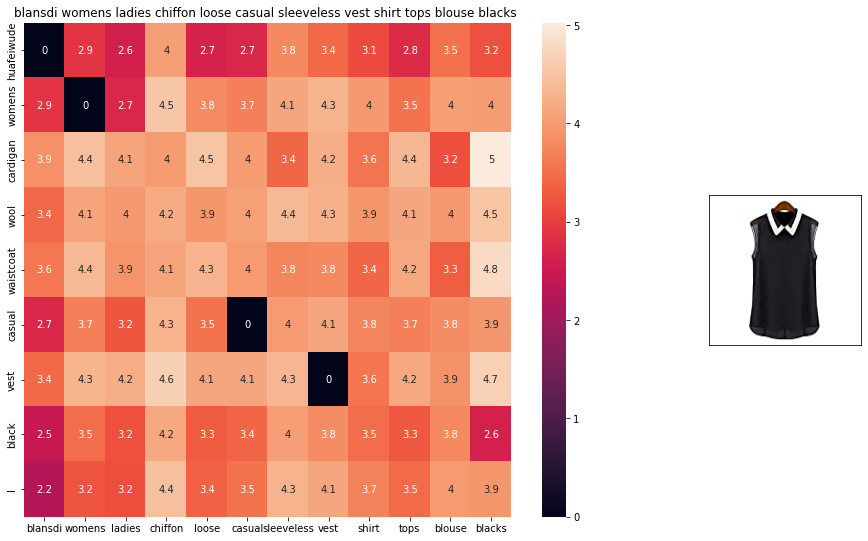

ASIN : B01B3Y99XA
BRAND : Blansdi
euclidean distance from given input image : 0.8936688


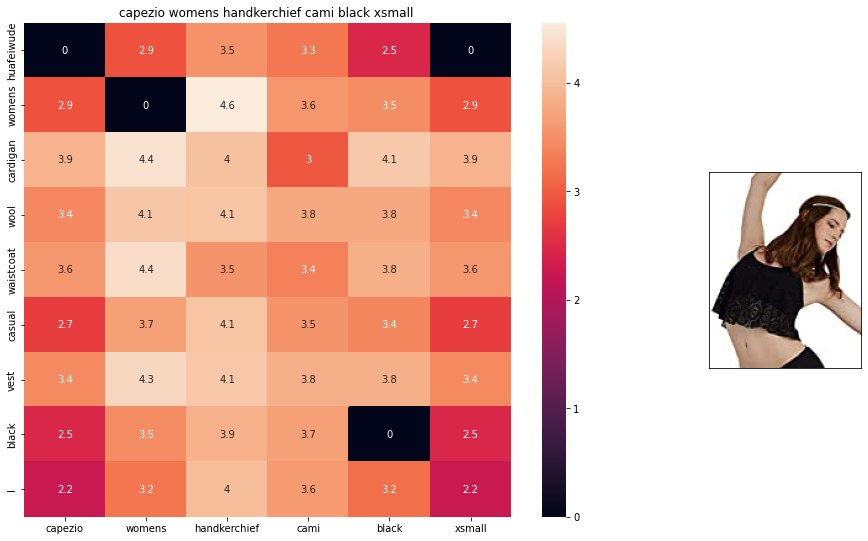

ASIN : B00ZIY47WA
BRAND : Capezio
euclidean distance from given input image : 0.89525115


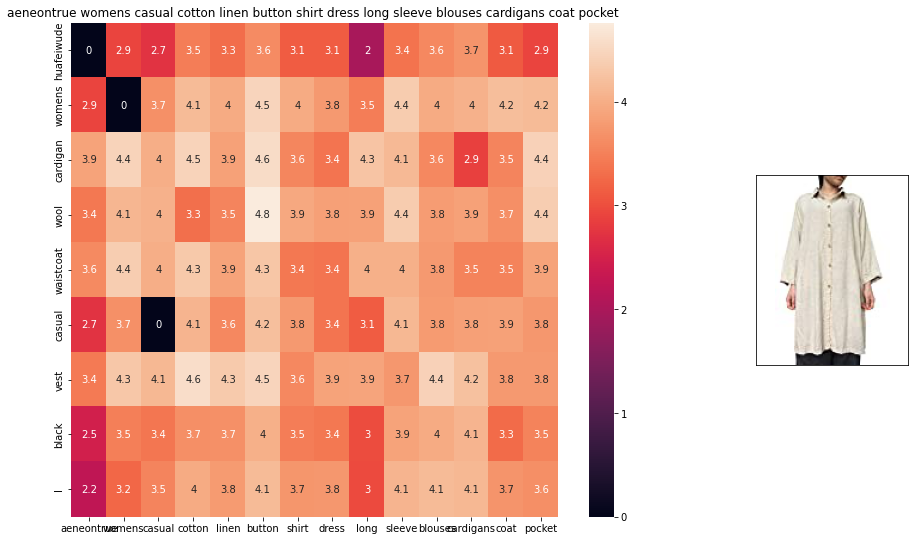

ASIN : B074V1K5QJ
BRAND : Aeneontrue
euclidean distance from given input image : 0.9028107


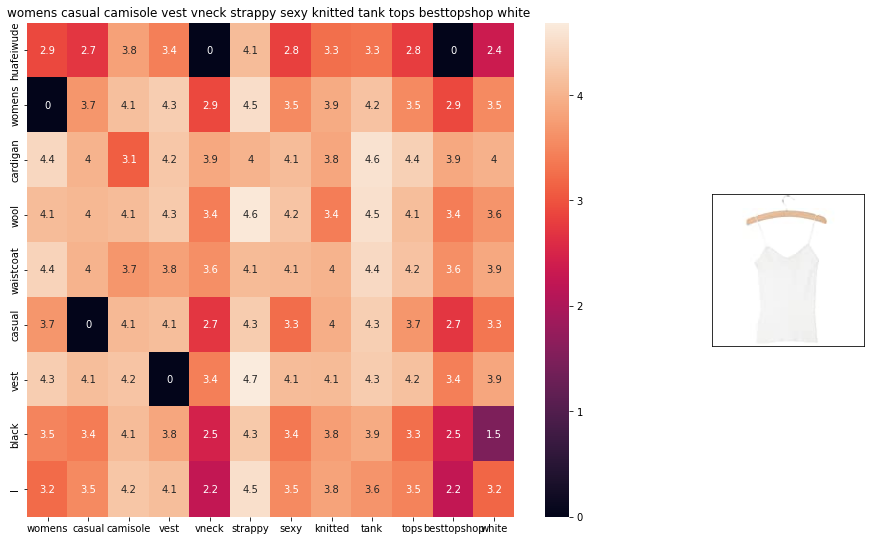

ASIN : B071XV9DKH
BRAND : Best Music Posters
euclidean distance from given input image : 0.9065367


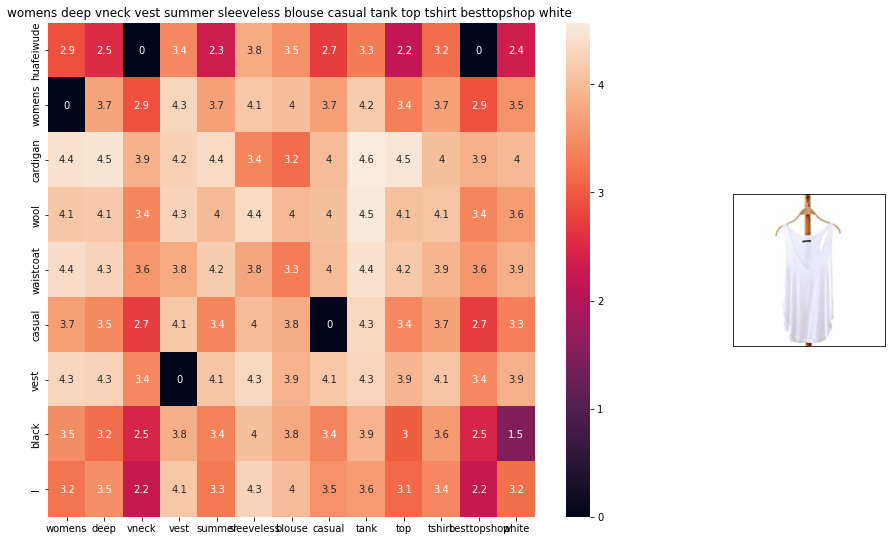

ASIN : B071Y6W6D8
BRAND : Best Music Posters
euclidean distance from given input image : 0.9093141


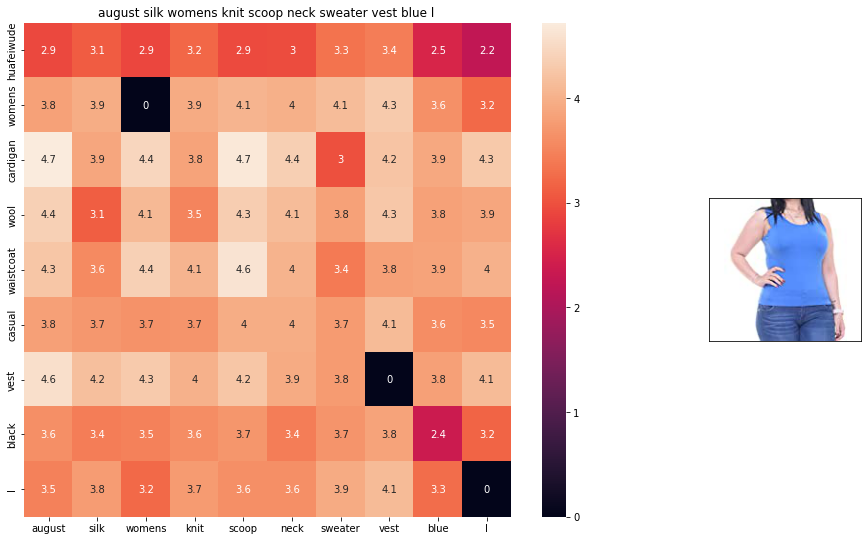

ASIN : B06X6N47HY
BRAND : August Silk
euclidean distance from given input image : 0.9097892


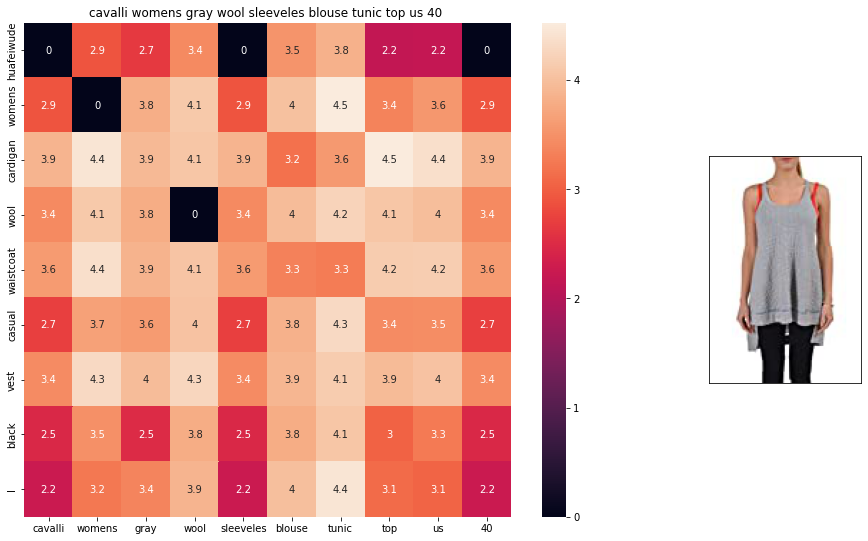

ASIN : B0175AT71K
BRAND : Just Cavalli
euclidean distance from given input image : 0.9117741


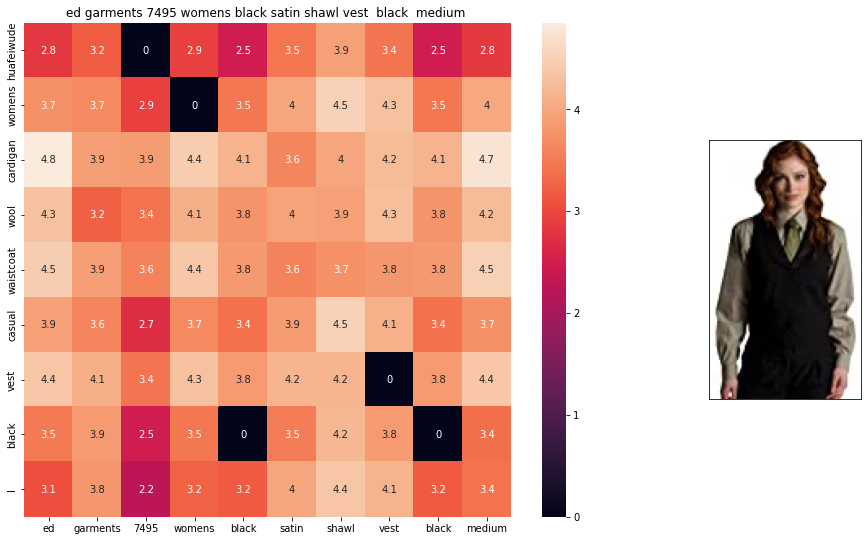

ASIN : B007X49OCG
BRAND : Edwards Garment
euclidean distance from given input image : 0.91356814


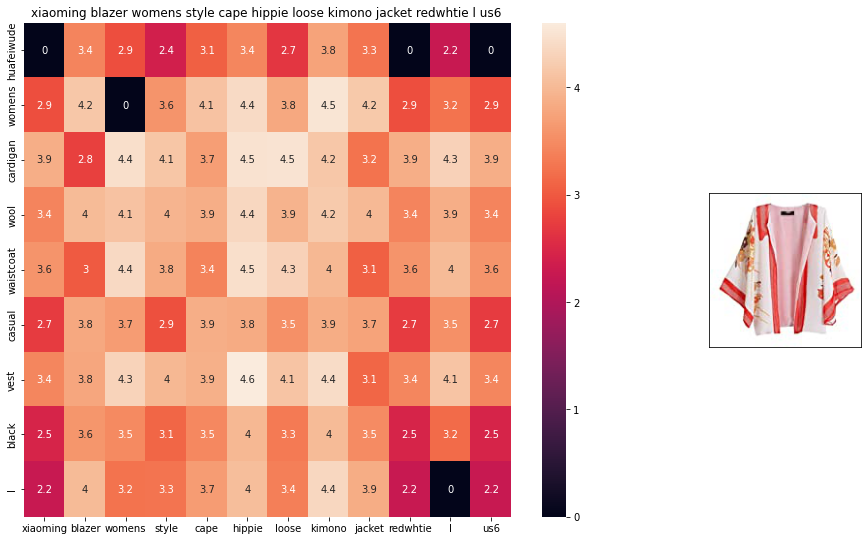

ASIN : B00WPK4T4G
BRAND : xiaoming
euclidean distance from given input image : 0.9149437


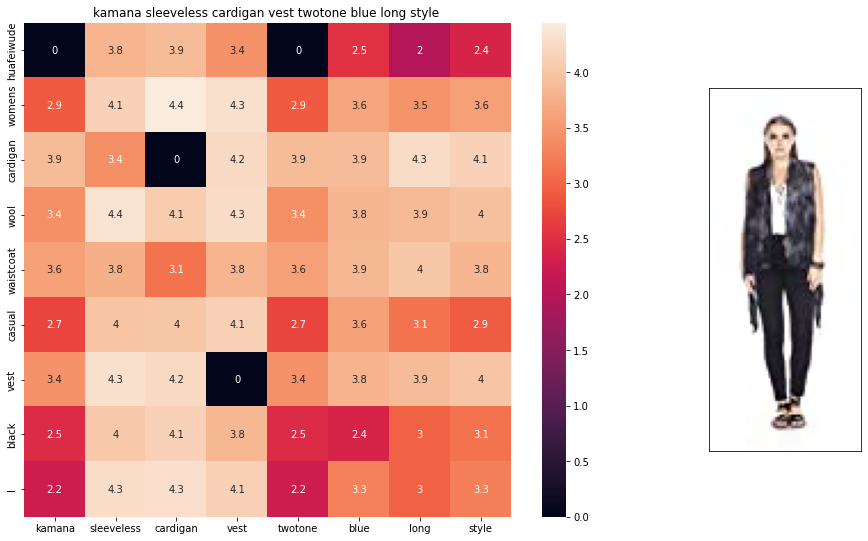

ASIN : B0751686K7
BRAND : Kamana
euclidean distance from given input image : 0.917094


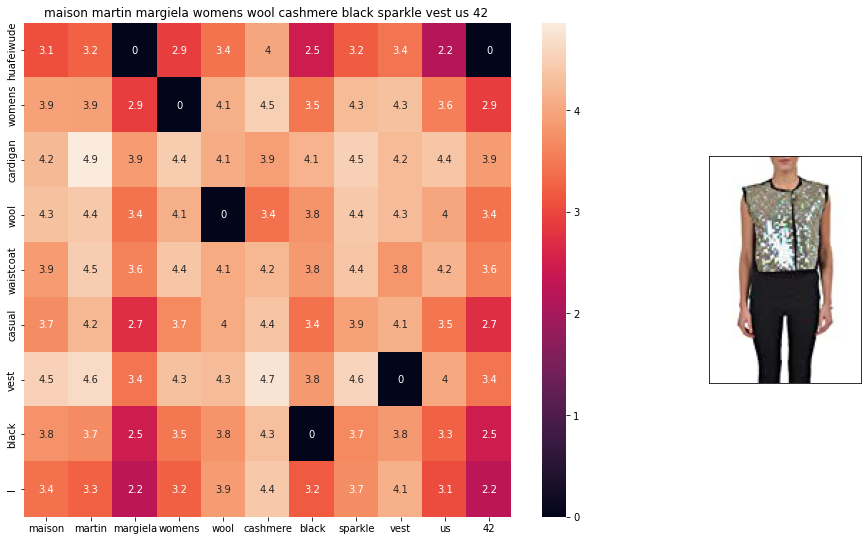

ASIN : B0175G7C20
BRAND : Maison Martin Margiela
euclidean distance from given input image : 0.9177549


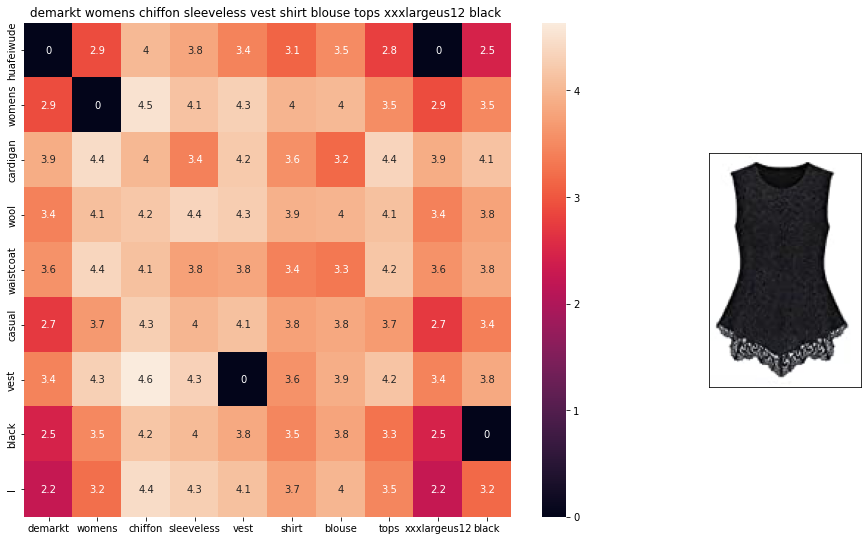

ASIN : B00JKCQZJE
BRAND : Demarkt
euclidean distance from given input image : 0.917883


In [23]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # dist(x, y) = sqrt(dot(x, x) - 2 * dot(x, y) + dot(y, y))
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(12566, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j

### TF-IDF weighted Word2Vec for product similarity


In [24]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

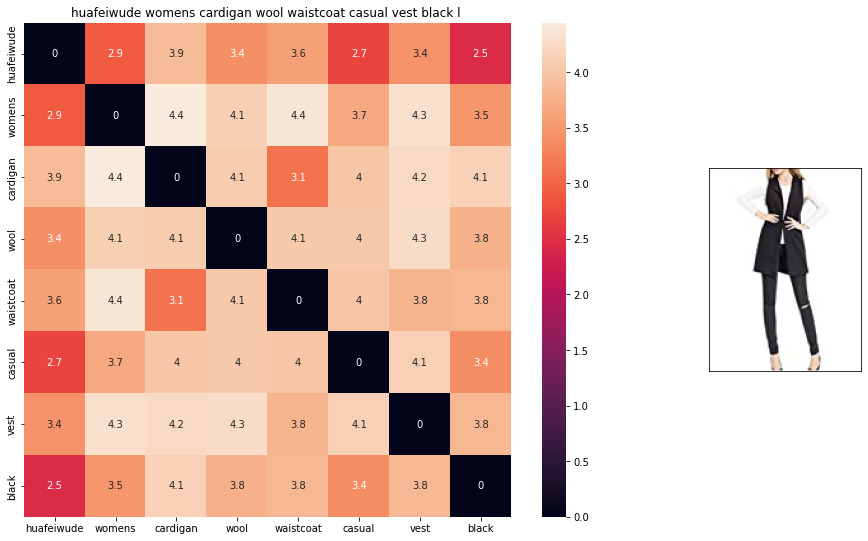

ASIN : B01MT96PXZ
Brand : Huafeiwude
euclidean distance from input : 0.0


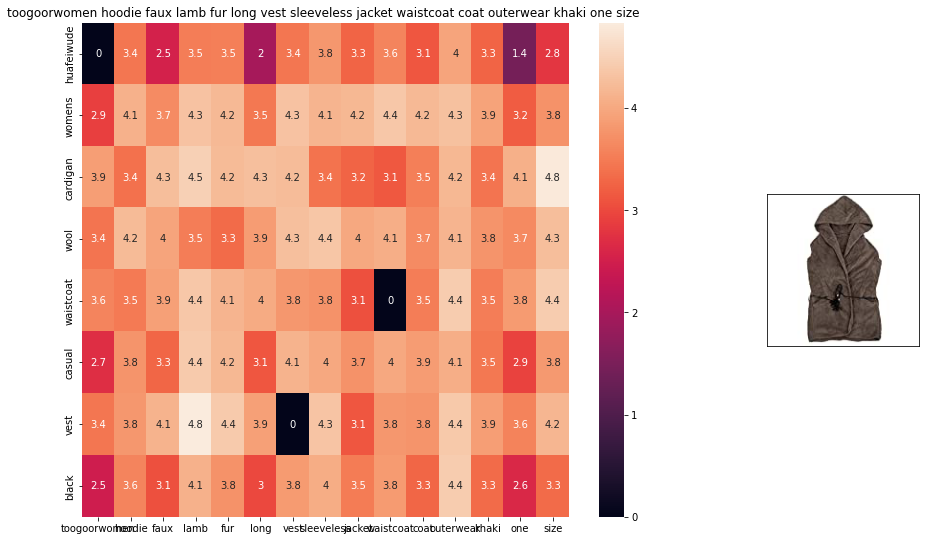

ASIN : B00R10GCHC
Brand : TOOGOO(R)
euclidean distance from input : 0.23149654


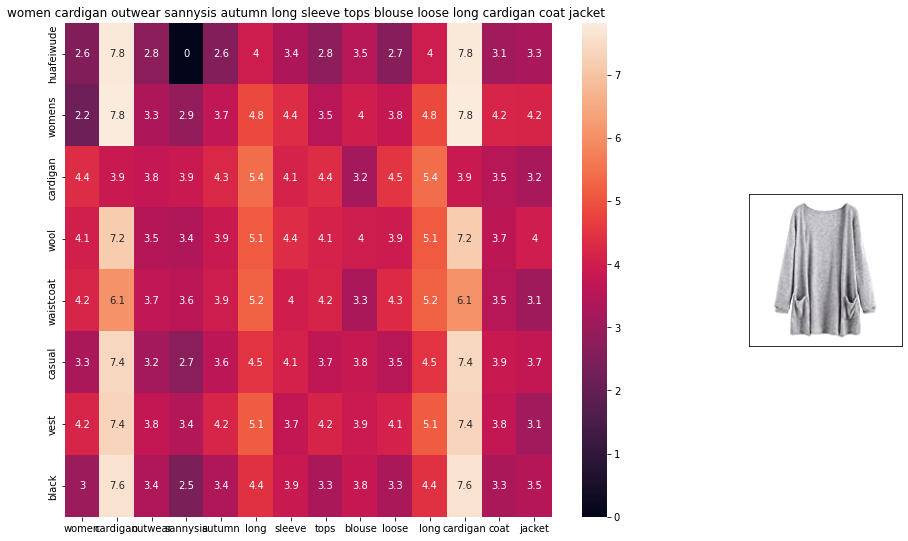

ASIN : B07473KFK1
Brand : Sannysis
euclidean distance from input : 0.24941687


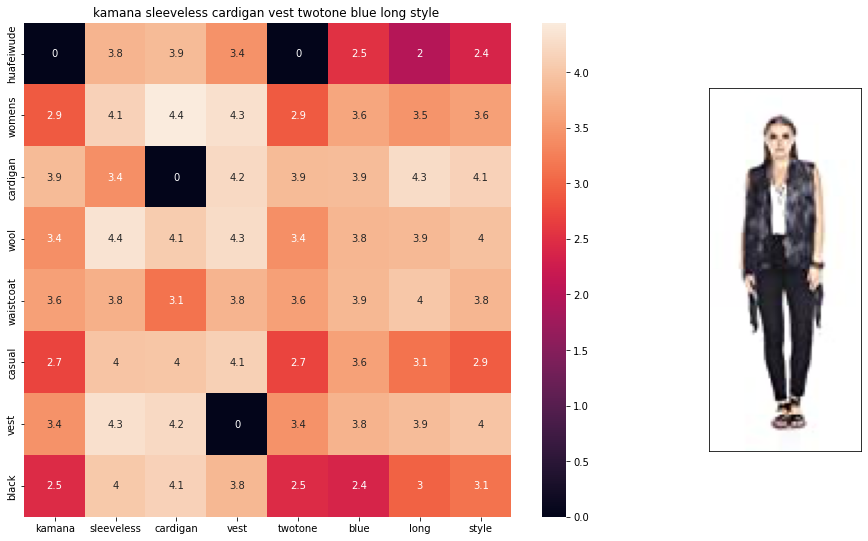

ASIN : B0751686K7
Brand : Kamana
euclidean distance from input : 0.26283455


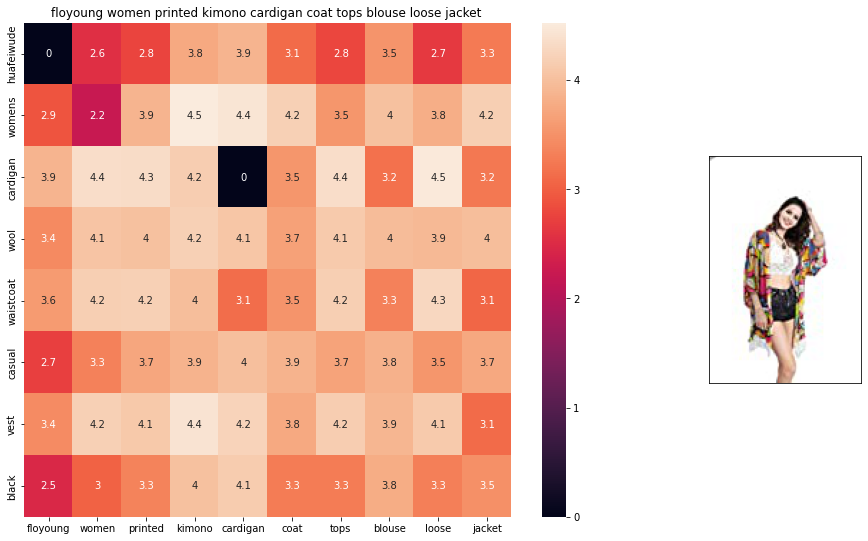

ASIN : B01D6EUG3W
Brand : FloYoung
euclidean distance from input : 0.26700047


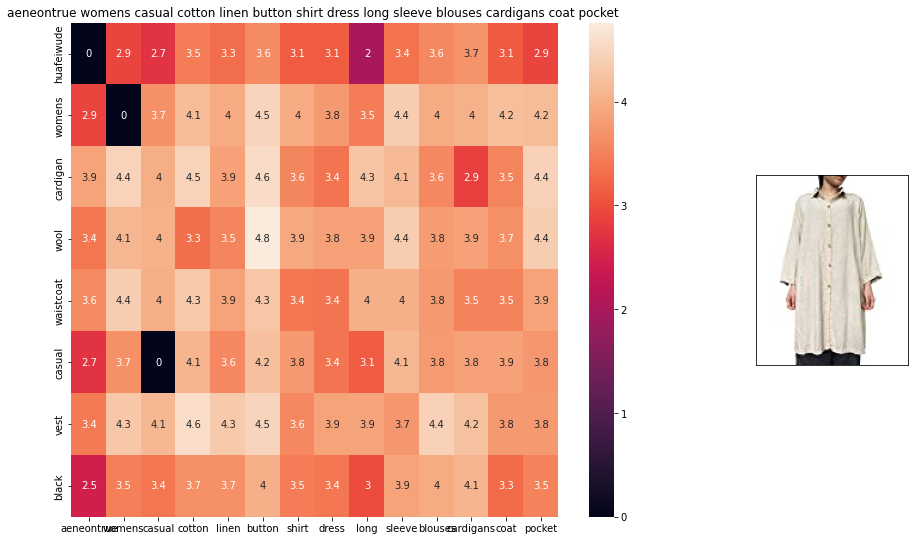

ASIN : B074V1K5QJ
Brand : Aeneontrue
euclidean distance from input : 0.2674007


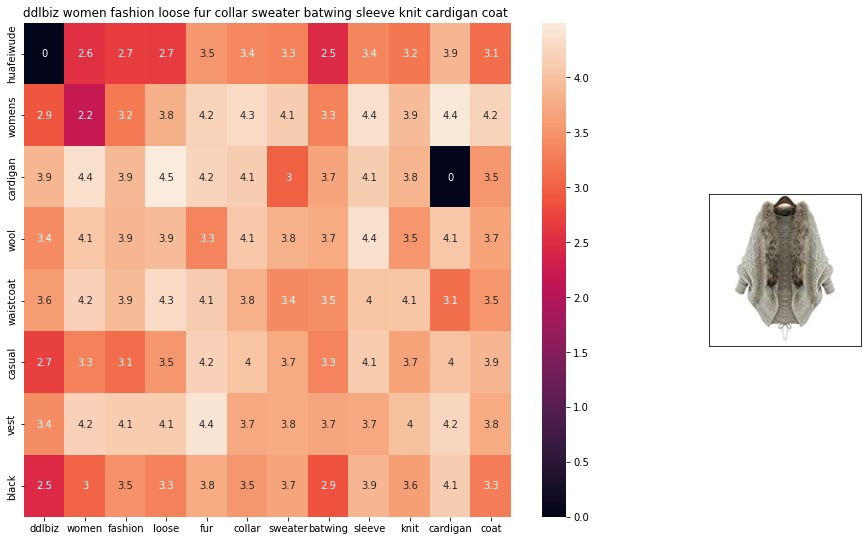

ASIN : B01MY76AQJ
Brand : DDLBiz
euclidean distance from input : 0.27476254


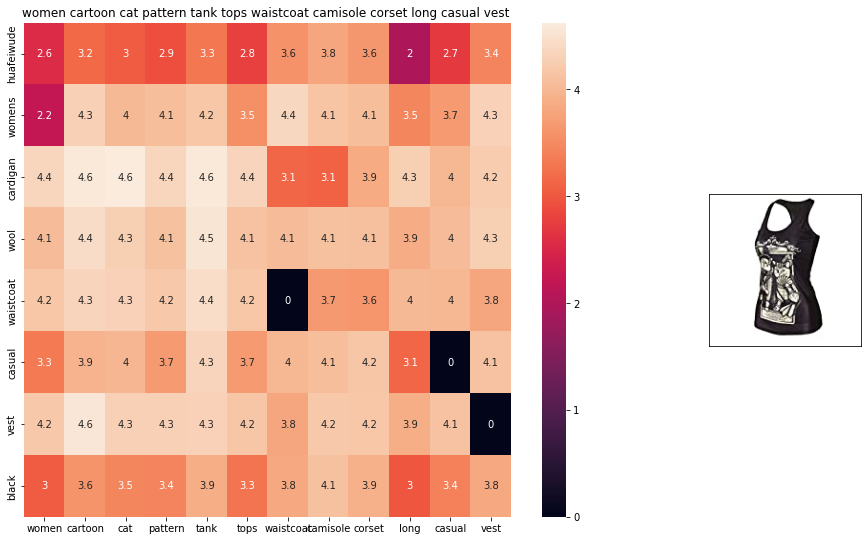

ASIN : B011R13YBM
Brand : Huayang
euclidean distance from input : 0.27867115


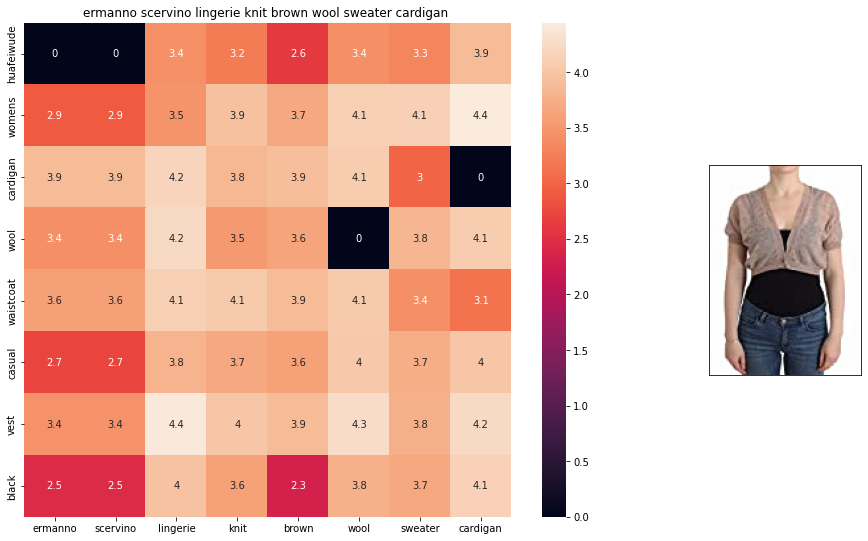

ASIN : B074G59T11
Brand : ERMANNO SCERVINO
euclidean distance from input : 0.2816291


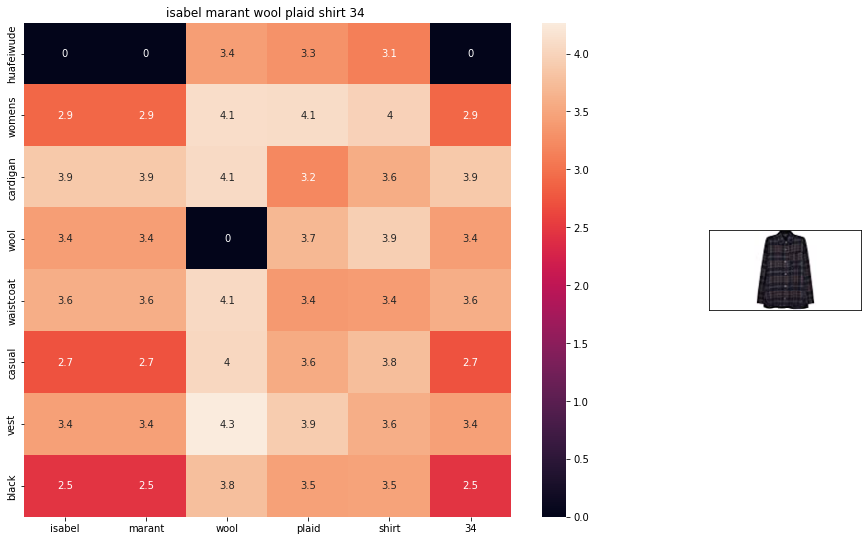

ASIN : B074NBDL2W
Brand : Isabel Marant
euclidean distance from input : 0.28391692


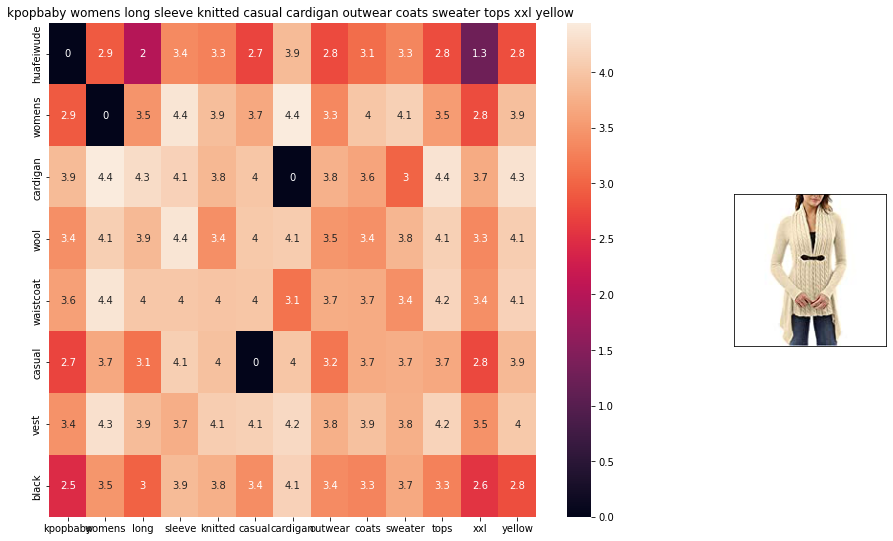

ASIN : B074LCPJJZ
Brand : KpopBaby
euclidean distance from input : 0.28413713


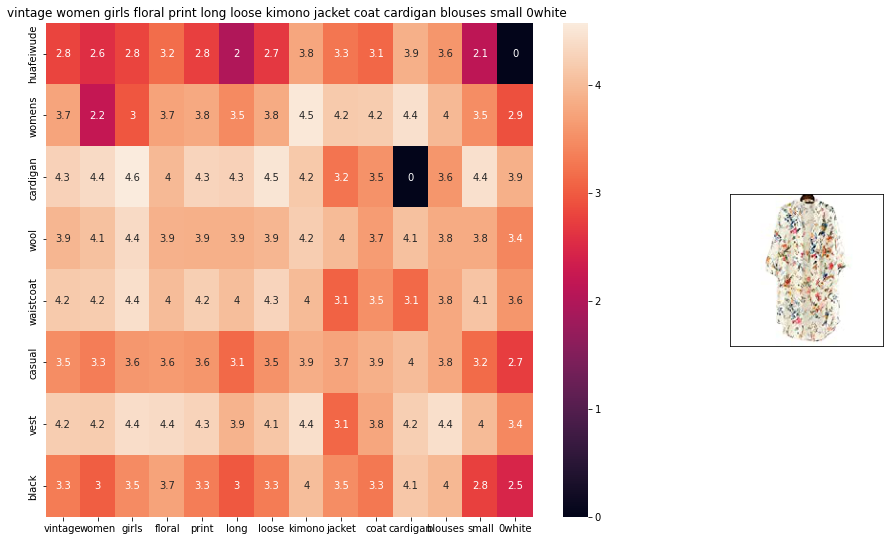

ASIN : B07375JCKD
Brand : ACEFAST INC
euclidean distance from input : 0.2847729


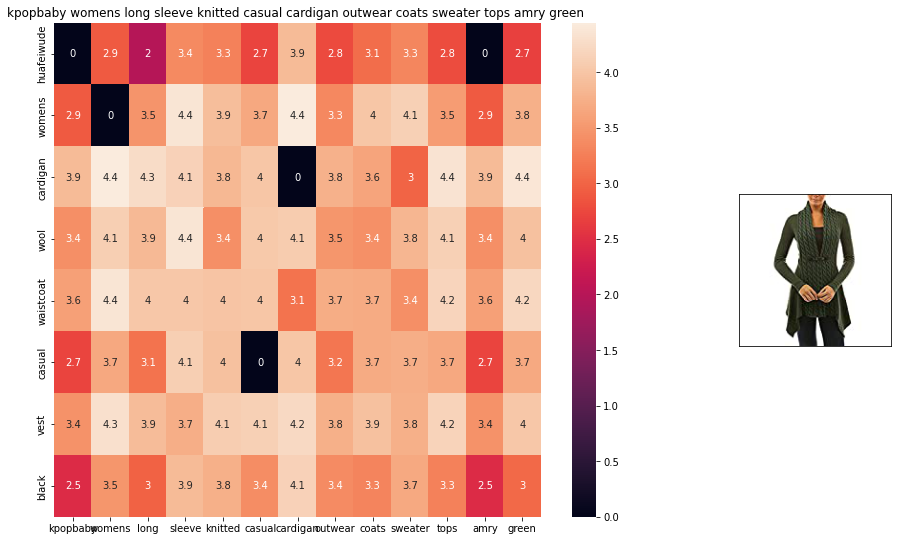

ASIN : B074LD7G7K
Brand : KpopBaby
euclidean distance from input : 0.2853667


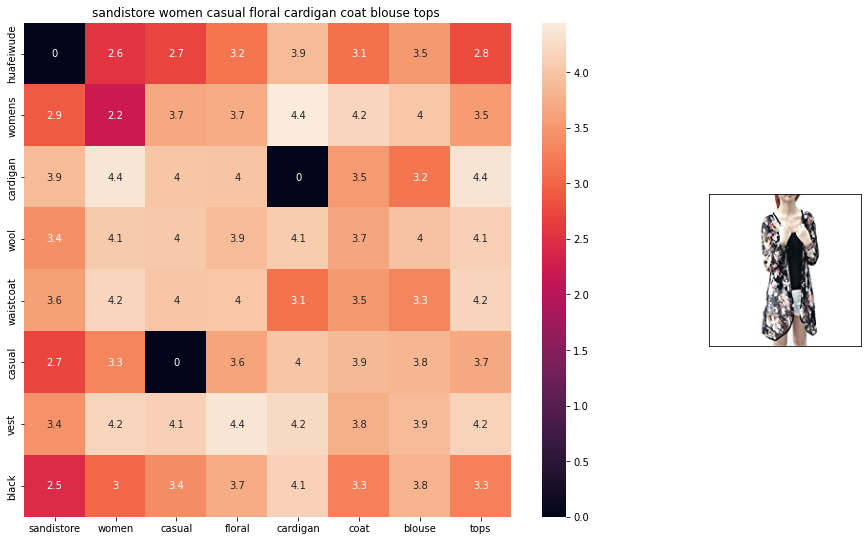

ASIN : B01AVX8IOU
Brand : Sandistore
euclidean distance from input : 0.2880725


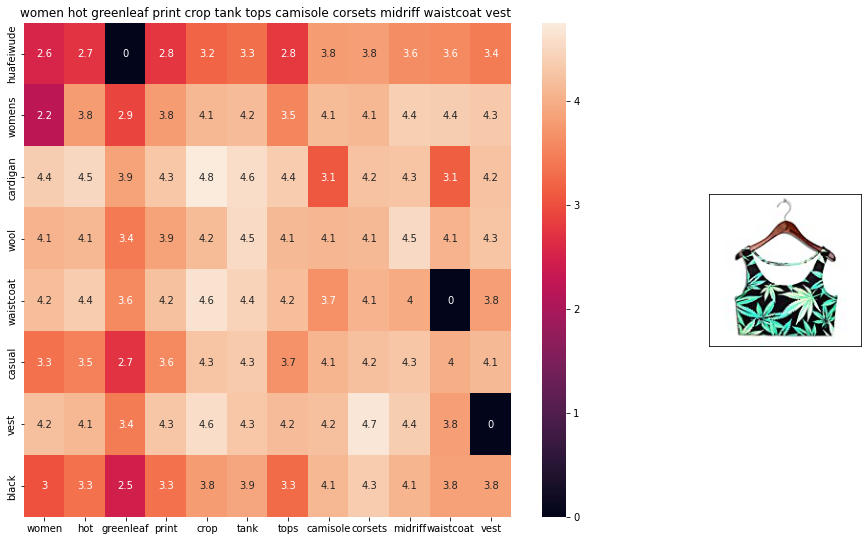

ASIN : B011R13OVW
Brand : Huayang
euclidean distance from input : 0.2916715


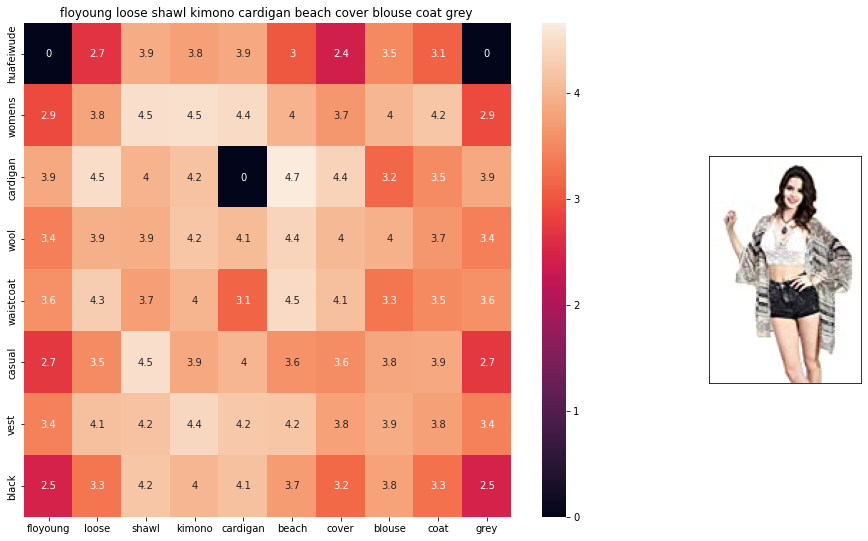

ASIN : B01D6EU9QG
Brand : FloYoung
euclidean distance from input : 0.29370075


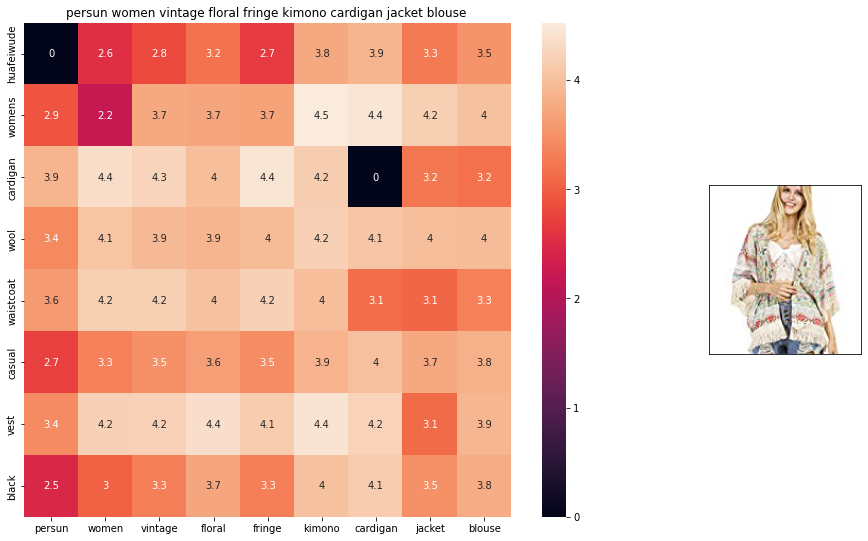

ASIN : B00Y26RSRQ
Brand : Persun
euclidean distance from input : 0.29476622


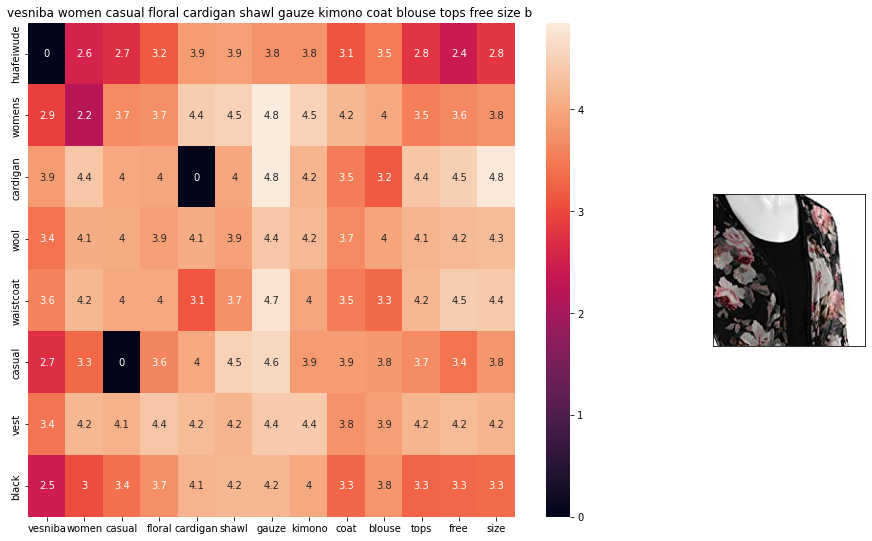

ASIN : B01JOGLQAS
Brand : VESNIBA
euclidean distance from input : 0.29720676


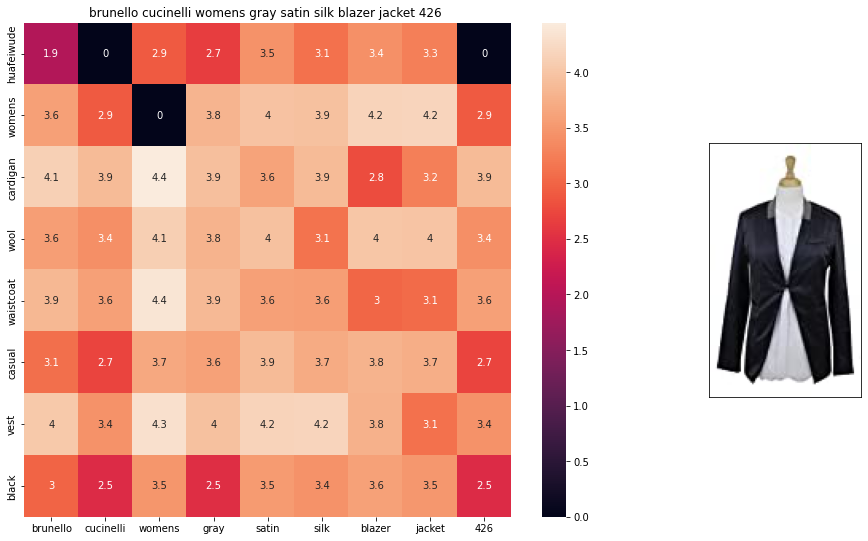

ASIN : B01IO1GL4U
Brand : Brunello Cucinelli
euclidean distance from input : 0.2978835


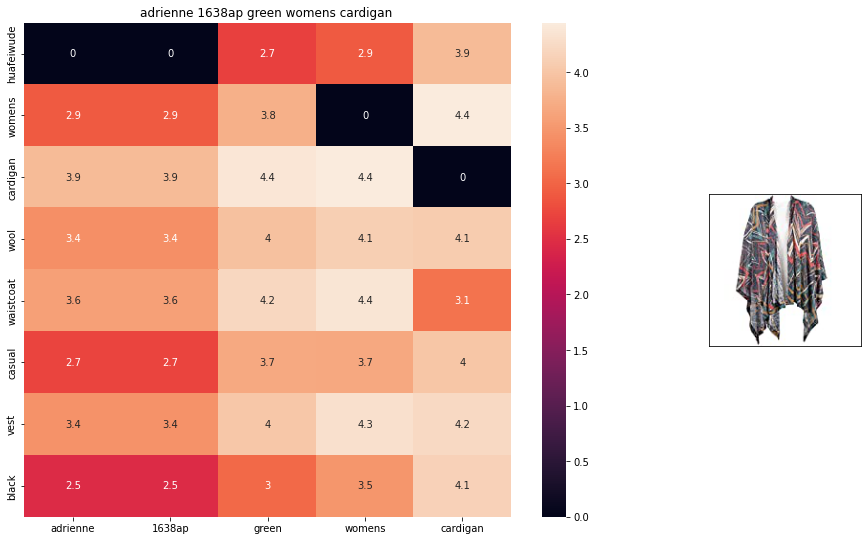

ASIN : B00O1HWO5W
Brand : Liuqiuhu
euclidean distance from input : 0.29811844


In [25]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the cosine distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

### Weighted similarity using brand and color.

In [27]:
data['brand'].isna().sum()

46

In [30]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value = "Not given", inplace = True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types  = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features   = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features   = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features   = color_vectorizer.fit_transform(colors)

extra_features   = hstack((brand_features, type_features, color_features)).tocsr() # Stack arrays in sequence horizontally (column wise).
# https://numpy.org/doc/stable/reference/generated/numpy.hstack.html 

print(type(extra_features))

<class 'scipy.sparse.csr.csr_matrix'>


In [31]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index = True, colorscale = colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # divide the whole figure space into 25 * 1:10 grids
    gs  = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5]) # all rows but only 10 columns as we have to leave behind 5 columns 
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot = True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

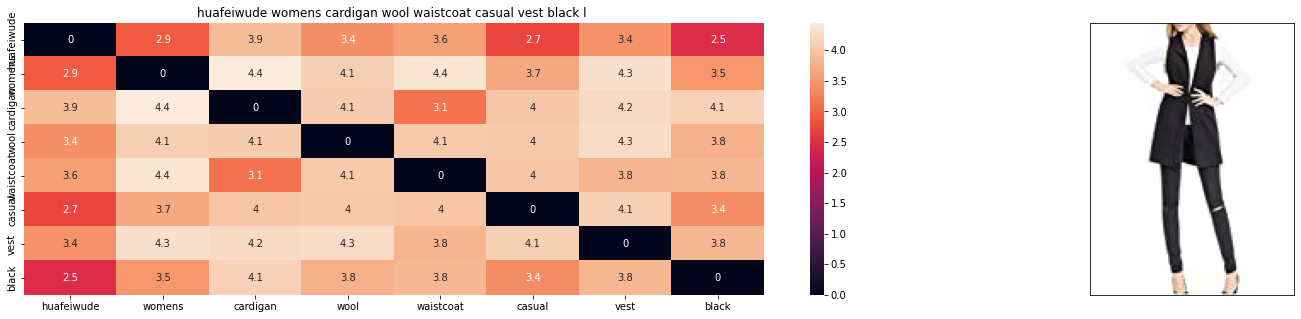

ASIN : B01MT96PXZ
Brand : Huafeiwude
euclidean distance from input : 0.0


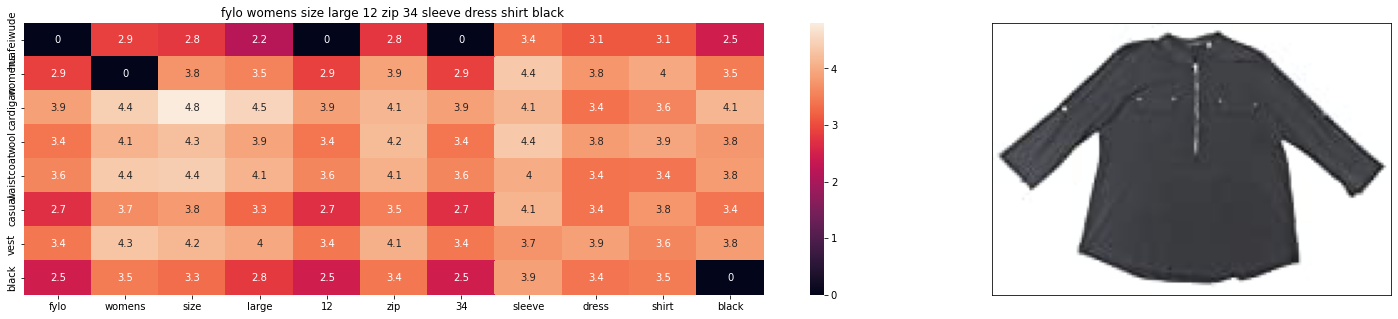

ASIN : B0718Y9J4M
Brand : f
euclidean distance from input : 0.6920001268386841


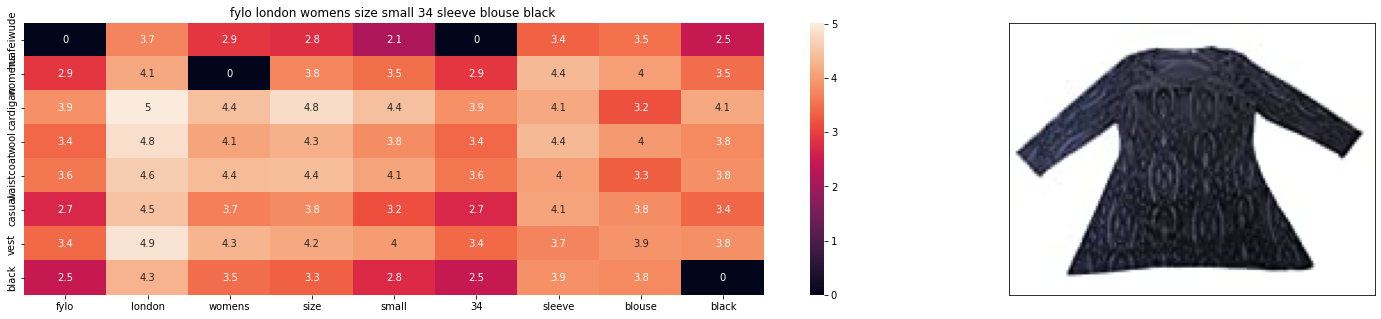

ASIN : B073HJRP1D
Brand : f
euclidean distance from input : 0.7161800861358643


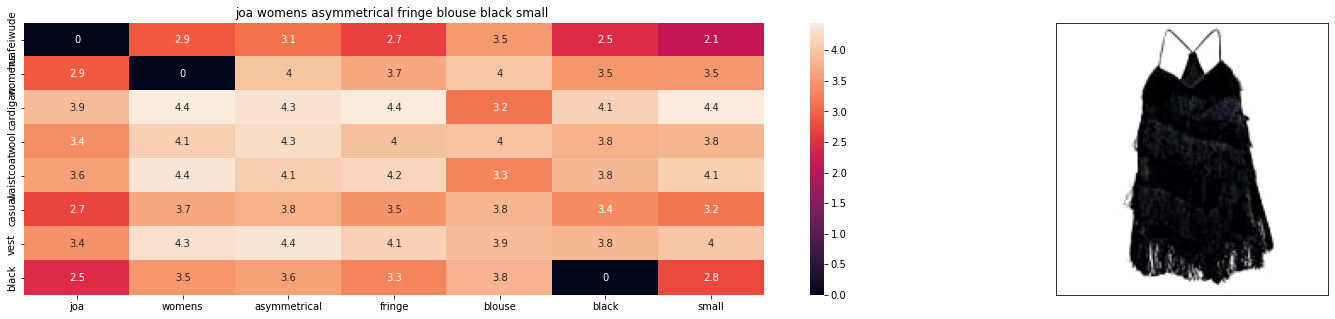

ASIN : B0721ZGF6S
Brand : J.O.A.
euclidean distance from input : 0.717557692527771


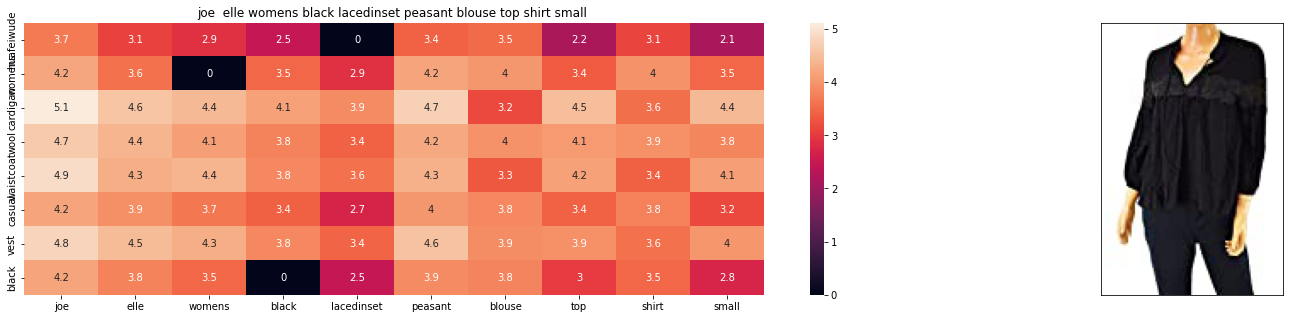

ASIN : B073GDVFT2
Brand : J&E
euclidean distance from input : 0.7204337358474732


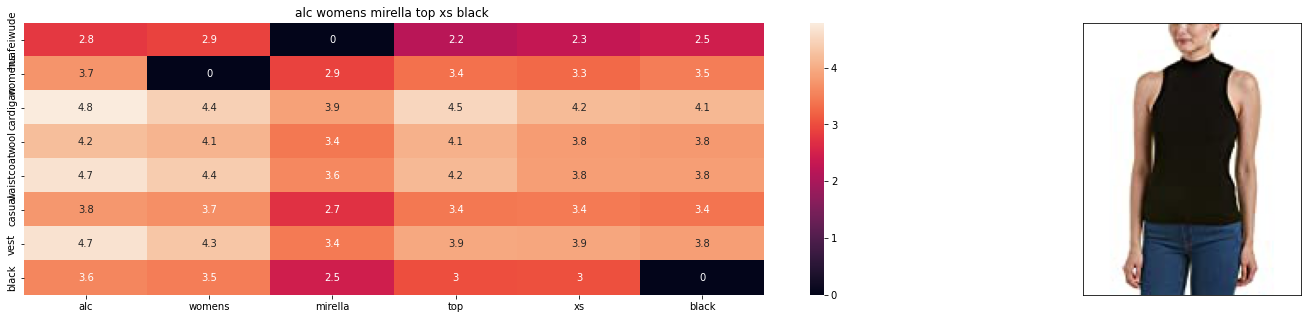

ASIN : B072N8CS7N
Brand : A.L.C.
euclidean distance from input : 0.7727357864379882


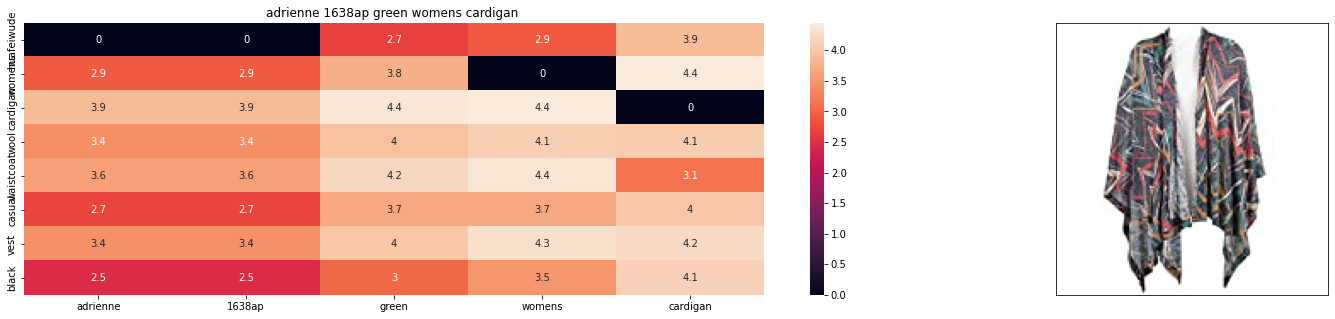

ASIN : B00O1HWO5W
Brand : Liuqiuhu
euclidean distance from input : 0.8561660053152707


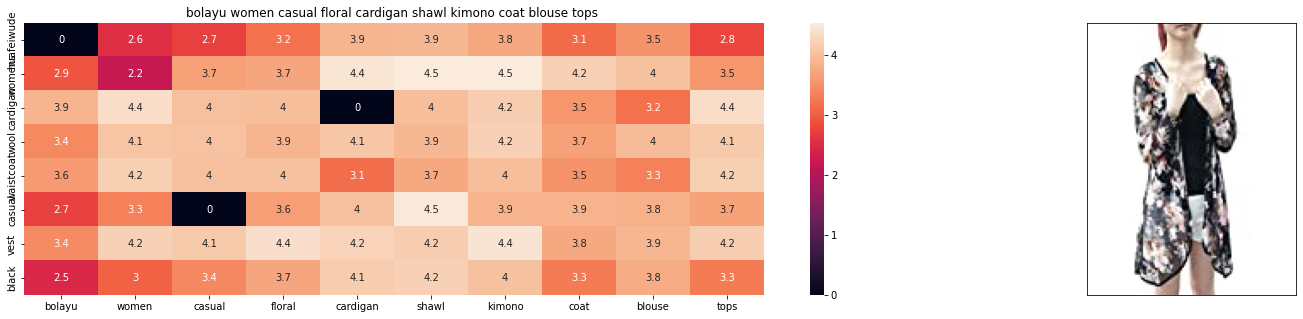

ASIN : B01F6UHWEU
Brand : Bolayu
euclidean distance from input : 0.856216621579614


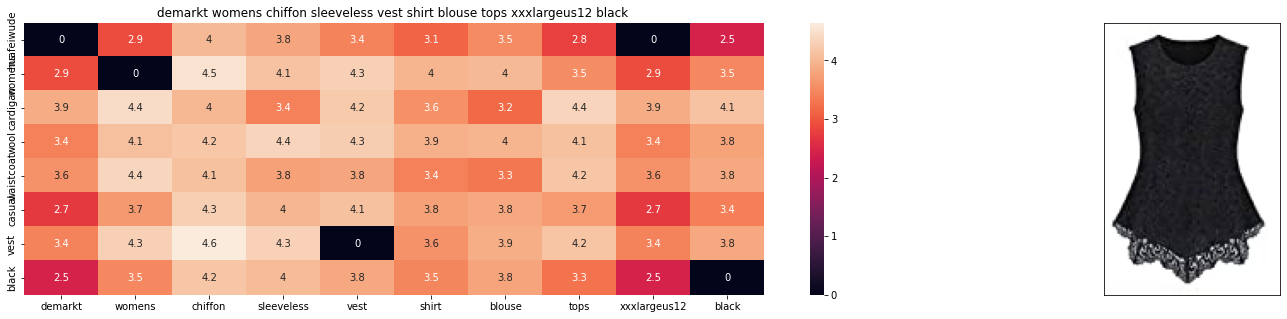

ASIN : B00JKCQZJE
Brand : Demarkt
euclidean distance from input : 0.8575074793715146


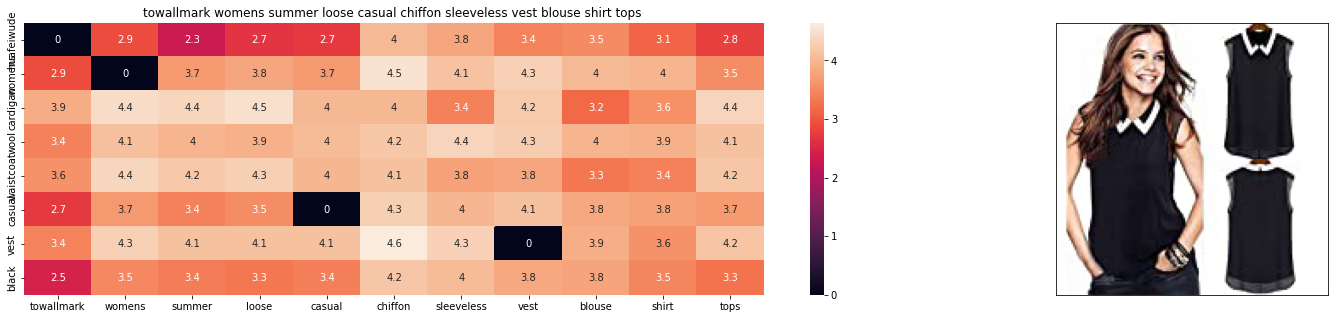

ASIN : B00QGEJ3MA
Brand : Towallmark
euclidean distance from input : 0.8601668121237424


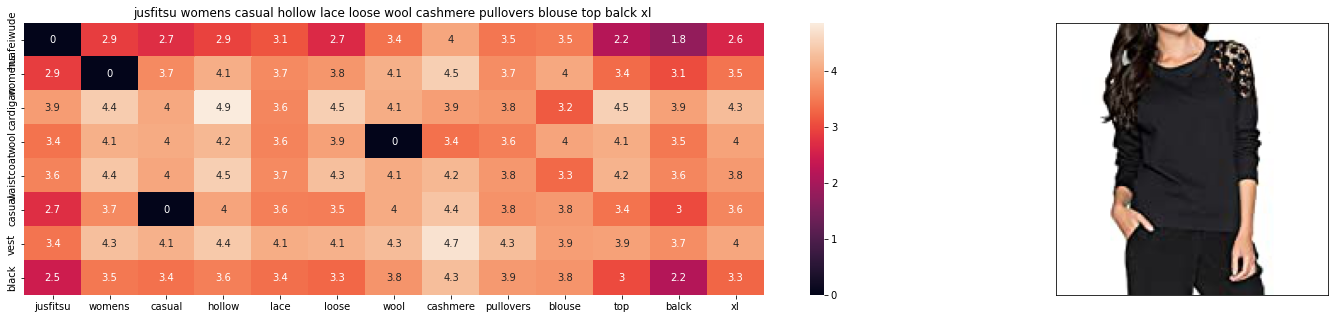

ASIN : B01N96GX38
Brand : Jusfitsu
euclidean distance from input : 0.8617479206938412


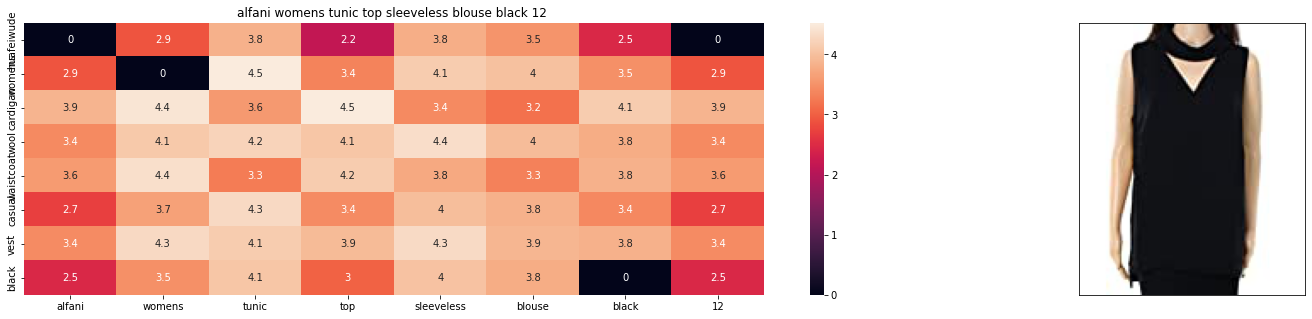

ASIN : B071V8VJJT
Brand : Alfani
euclidean distance from input : 0.8654532553572324


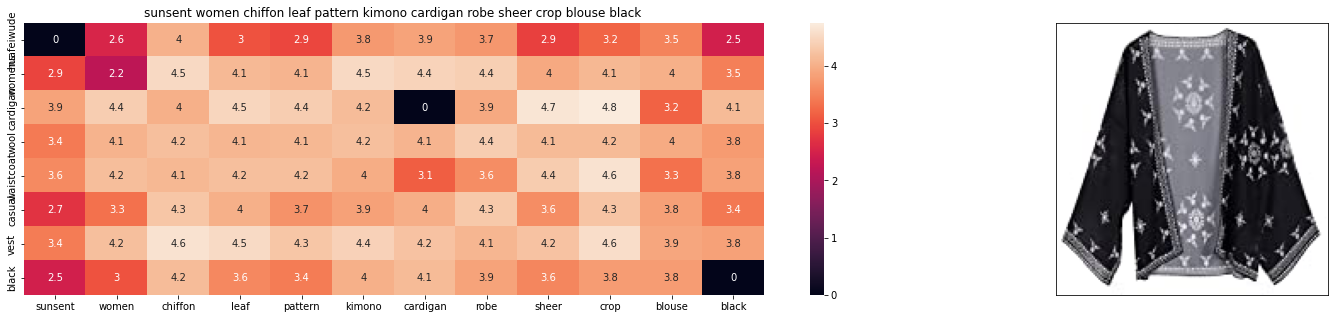

ASIN : B01EL5PD6U
Brand : Sunsent
euclidean distance from input : 0.8657069446463254


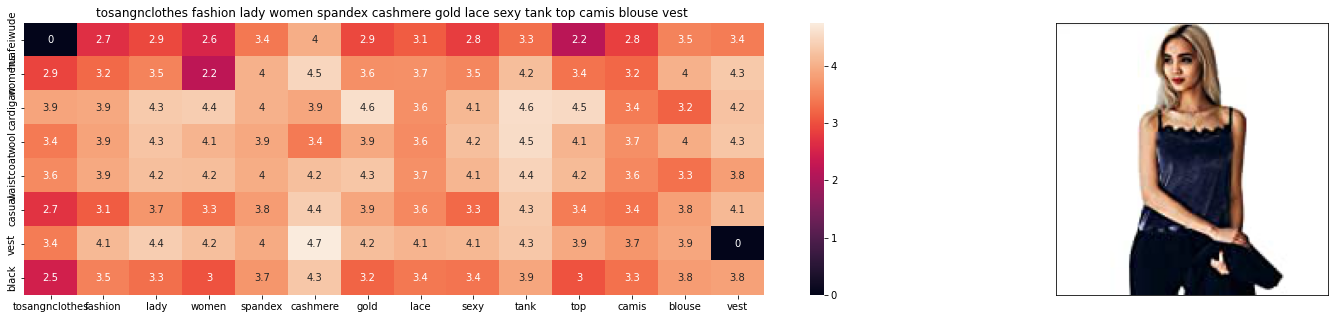

ASIN : B06XFFQLPL
Brand : Tosangn_Clothes
euclidean distance from input : 0.8657842161078122


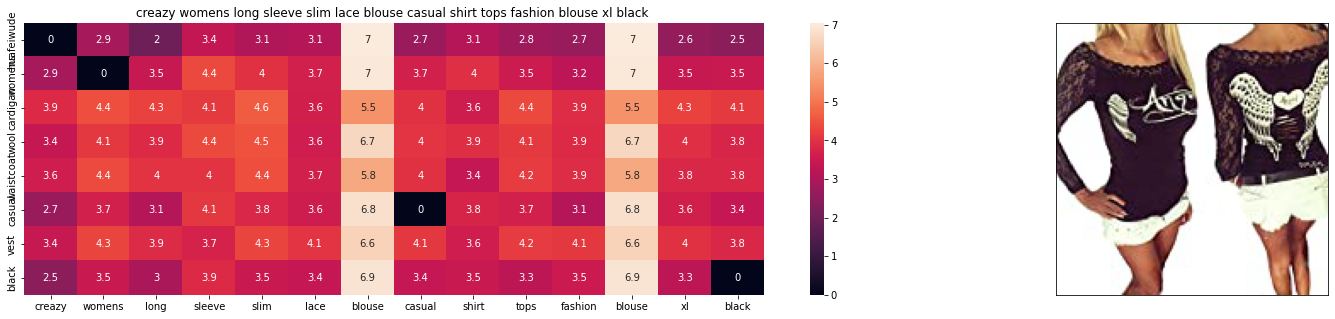

ASIN : B01EV1NKNW
Brand : Creazy
euclidean distance from input : 0.8666322233099606


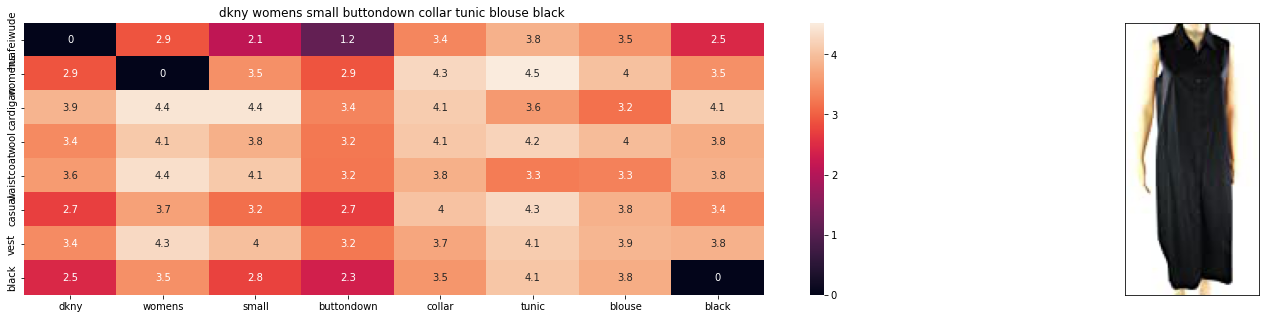

ASIN : B0716YWPN1
Brand : DKNY
euclidean distance from input : 0.8671160699743894


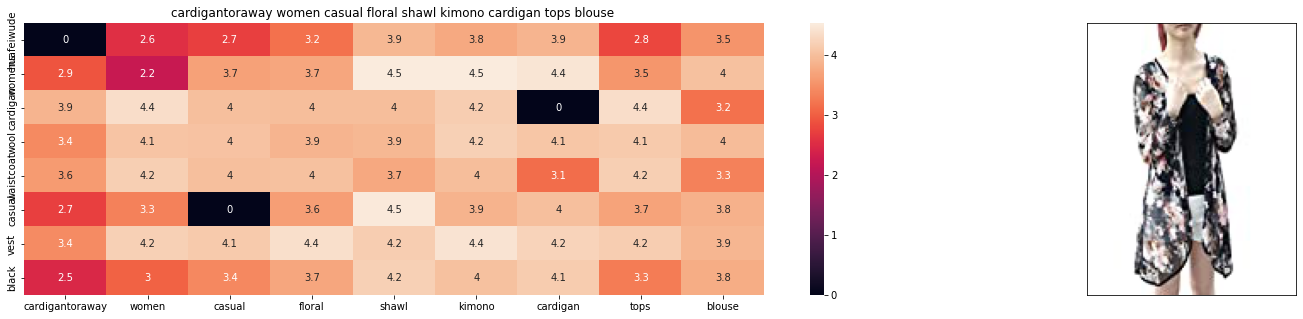

ASIN : B01CZMPCY4
Brand : Toraway
euclidean distance from input : 0.8674418689627317


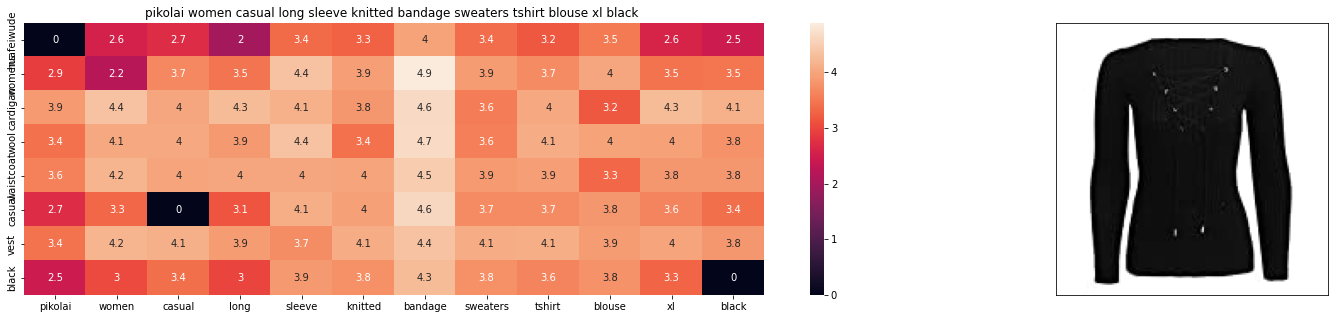

ASIN : B01LZ2B1HT
Brand : Pikolai
euclidean distance from input : 0.8679118754286435


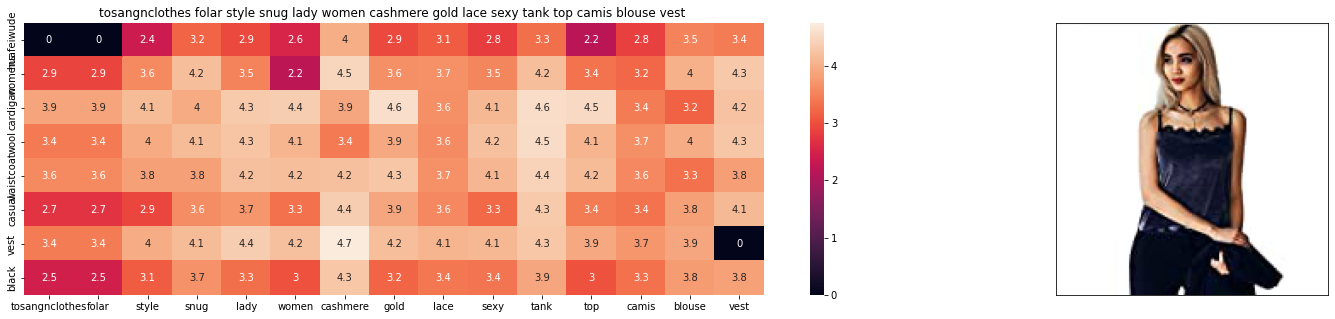

ASIN : B06XFRDH4J
Brand : Tosangn_Clothes
euclidean distance from input : 0.8691548945326474


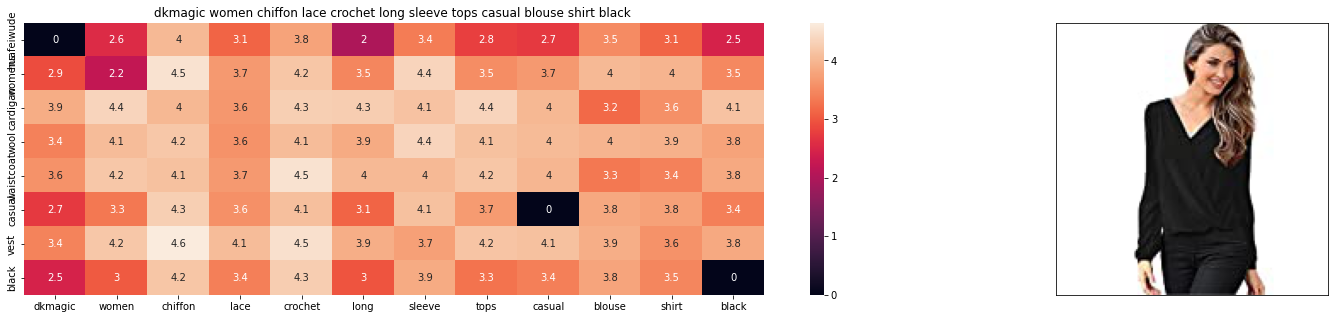

ASIN : B01LW6J44P
Brand : DKmagic
euclidean distance from input : 0.8704884292502072


In [32]:
def tf_idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: apparel's id in given corpus
    # w1: weight for  w2v features
    # w2: weight for brand and color features

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity

    tf_idf_w2v_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    ex_feat_dist    = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * tf_idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

tf_idf_w2v_brand(12566, 5, 5, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j